# Figure S8

Script to generate Figure S8 from the Supplementary Materials of [1]. This figure shows the long-term durability testing.

Using auxetic sensor (3-ply PPy coated core, green wire winding)

Initial lengh: 200 mm

Date of data collection: 2023-11-09

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. _Science Advances_. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [1]:
library(scales)
library(ggplot2)
library(cowplot)
library(ggh4x)
library(dplyr)
library(broom)
library(tidyverse)
library(magick)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ lubridate::stamp()  masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to ImageMagick 6.9.12.98
Enabled features: cairo, freetype, fftw, ghostscript, heic, lcms, pango, raw, rsvg, webp
Disabled features: fontconfig, x11



In [2]:
RCparallel <- function(i, q, f) {
    i2q2 <- i^2+ q^2
    rp <- i2q2/i
    cp <- -1*q/(2*pi*f*i2q2)
    return(list(rp, cp))
}
RCseries <- function(i, q, f) {
    rs <- i
    cs <- -1/(2*pi*f*q)
    return(list(rs, cs))
}

## Import LCR Data Files

Collected data on the gold standard LCR meter, but these may only be measured with one excitation frequency at a time.

In [3]:
PATH_PREFIX <- ".\\Data\\Synchronized\\LCR"
REGEX_PATTERN <- "^\\d{4}-\\d{2}-\\d{2}T\\d{6}_([^_]+)_Test(\\d+)_f(\\d{3})_([^_.]+).tsv$"
exc_freq <- c(99609.0, 49805.0, 24902.0, 12451.0)
files <- list.files(path=PATH_PREFIX, pattern=REGEX_PATTERN, no..=TRUE)
print(files)
lcr <- data.frame()
for (file in files) {
    d <- read.csv(file = file.path(PATH_PREFIX, file), header=TRUE, col.names=c("time", "position", "force", "displacement", "strain", "Zmag", "Zphase", "Cs", "Rs"), sep="\t")
    parsed_filename <- regexec(REGEX_PATTERN, file)
    start <- unlist(parsed_filename)[2:5]
    end <- start + attr(parsed_filename[[1]], "match.length")[2:5] - 1
    I <- d$Zmag*cos(d$Zphase*pi/180.0)
    Q <- d$Zmag*sin(d$Zphase*pi/180.0)
    rpcp <- RCparallel(I, Q, d$f)
    rscs <- RCseries(I, Q, d$f)
    
    df <- data.frame(method = rep(substr(file, start[1], end[1]), nrow(d)),
                     test.num = rep(substr(file, start[2], end[2]), nrow(d)),
                     freq = as.numeric(rep(substr(file, start[3], end[3]), nrow(d)))*1000,
                     segment = rep(substr(file, start[4], end[4]), nrow(d)),
                     time = d$time,
                     position = d$position,
                     force = d$force,
                     displacement = d$displacement,
                     strain = d$strain,                     
                     Zmag = d$Zmag,
                     Zphase = d$Zphase,
                     I = I,
                     Q = Q,
                     Rp = rpcp[[1]],
                     Cp = rpcp[[2]],
                     Rs = d$Rs,
                     Cs = d$Cs,
                     dCC0 = (d$Cs - d$Cs[1])/d$Cs[1])
    lcr <- rbind(lcr, df)
}
lcr$device = "LCR"
head(lcr)
#save(lcr, file = file.path(PATH_PREFIX, "Data.Rda"))
#write.csv(lcr, file=file.path(PATH_PREFIX, "Data.csv"))

 [1] "2023-11-09T143802_StressStrain25_Test1_f001_ALL.tsv" 
 [2] "2023-11-09T144323_StressStrain25_Test2_f012_ALL.tsv" 
 [3] "2023-11-09T144721_StressStrain25_Test3_f025_ALL.tsv" 
 [4] "2023-11-09T145148_StressStrain25_Test4_f012_ALL.tsv" 
 [5] "2023-11-09T150016_StressStrain25_Test6_f025_ALL.tsv" 
 [6] "2023-11-09T150525_StressStrain25_Test8_f050_ALL.tsv" 
 [7] "2023-11-09T150934_StressStrain25_Test9_f100_ALL.tsv" 
 [8] "2023-11-09T151454_StressStrain25_Test10_f001_BOT.tsv"
 [9] "2023-11-09T151454_StressStrain25_Test11_f001_TOP.tsv"
[10] "2023-11-09T153314_StressStrain25_Test12_f001_ALL.tsv"
[11] "2023-11-09T164550_StressStrain25_Test22_f001_ALL.tsv"
[12] "2023-11-09T164945_StressStrain25_Test23_f001_BOT.tsv"
[13] "2023-11-09T165403_StressStrain25_Test24_f001_TOP.tsv"
[14] "2023-11-09T165858_StressStrain25_Test25_f012_ALL.tsv"
[15] "2023-11-09T170404_StressStrain25_Test26_f025_ALL.tsv"
[16] "2023-11-09T170816_StressStrain25_Test27_f050_ALL.tsv"
[17] "2023-11-09T171223_StressStrain25_T

,method,test.num,freq,segment,time,position,force,displacement,strain,Zmag,Zphase,I,Q,Rp,Cp,Rs,Cs,dCC0,device
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,StressStrain25,1,1000,ALL,0.00,-28.17782,1.338492,-28.17783,0.000000e+00,3787380,-88.41100,105023.0,-3785924,136581944,3.138329e-08,105024.0,4.203860e-11,0.000000e+00,LCR
2,StressStrain25,1,1000,ALL,0.01,-28.17797,1.357449,-28.17797,-8.321234e-07,3787308,-88.41172,104973.4,-3785853,136641246,3.094561e-08,104971.0,4.203939e-11,1.879225e-05,LCR
3,StressStrain25,1,1000,ALL,0.02,-28.17807,1.606690,-28.17807,-1.393312e-06,3787237,-88.41243,104924.6,-3785783,136699777,2.614561e-08,104918.1,4.204017e-11,3.734663e-05,LCR
4,StressStrain25,1,1000,ALL,0.03,-28.17809,1.493972,-28.17810,-1.543228e-06,3787216,-88.41340,104859.9,-3785764,136782571,2.811843e-08,104849.8,4.204040e-11,4.281779e-05,LCR
5,StressStrain25,1,1000,ALL,0.04,-28.17812,1.394362,-28.17812,-1.702085e-06,3787388,-88.41537,104734.5,-3785940,136958795,3.012581e-08,104722.6,4.203843e-11,-4.043903e-06,LCR
6,StressStrain25,1,1000,ALL,0.05,-28.17812,1.303470,-28.17812,-1.683884e-06,3787561,-88.41733,104609.7,-3786116,137134627,3.222506e-08,104595.4,4.203647e-11,-5.066772e-05,LCR


## Import Sensor Board Data

Data collected using the custom sensor board hardware.

In [4]:
avg_limit_low <- 100
avg_limit_high <- 400
PATH_PREFIX <- ".\\Data\\Synchronized\\SensBoard"
REGEX_PATTERN <- "^\\d{4}-\\d{2}-\\d{2}T\\d{6}_([^_]+)_Test(\\d+)_SensBoard_([^_.]+).tsv$"
files <- list.files(path=PATH_PREFIX, pattern=REGEX_PATTERN, no..=TRUE, recursive=TRUE)
f <- c(99609.0, 49805.0, 24902.0, 12451.0)
sensor_board <- data.frame()
for (file in files) {
    print(file)
    d <- read.csv(file = file.path(PATH_PREFIX, file), sep = '\t', header=TRUE, col.names=c("time", "position", "force", "displacement", "strain", "i0", "q0", "i1", "q1", "i2", "q2", "i3", "q3"))
    parsed_filename <- regexec(REGEX_PATTERN, file)
    start <- unlist(parsed_filename)[2:4]
    end <- start + attr(parsed_filename[[1]], "match.length")[2:4] - 1
    trial <- strtoi(substr(file, 4, 4))
    d$i0 <- d$i0*1.4253 -  82.30
    d$i1 <- d$i1*1.1516 - 125.95
    d$i2 <- d$i2*1.0519 - 108.39
    d$i3 <- d$i3*1.0344 - 110.18
    d$q0[d$i0<d$q0] <- d$q0[d$i0<d$q0]*6.1726 - 39098.0
    d$q0[d$i0>=d$q0] <- d$q0[d$i0>=d$q0]*2.0730 - 1068.5
    d$q1 <- d$q1*1.8172 - 2094.8
    d$q2 <- d$q2*1.2834 - 3640.2
    d$q3 <- d$q3*1.1780 - 1820.6
    I <- c(d$i0, d$i1, d$i2, d$i3)
    Q <- c(d$q0, d$q1, d$q2, d$q3)
    Zmag <- 2.0*sqrt(I^2 + Q^2)
    Zphase <- atan2(Q, I)*180/pi
    rpcp <- RCparallel(I, Q, rep(f, each=nrow(d)))
    rscs <- RCseries(I, Q, rep(f, each=nrow(d)))
    df <- data.frame(method=rep(substr(file, start[1], end[1]), length(f)*nrow(d)),
                     test.num = rep(substr(file, start[2], end[2]), nrow(d)),
                     freq = rep(f, each=nrow(d)),
                     segment = rep(substr(file, start[3], end[3]), nrow(d)),
                     time = rep(d$time, length(f)),
                     position = rep(d$position, length(f)),
                     force = rep(d$force, length(f)),
                     displacement = rep(d$displacement, length(f)),
                     strain = rep(d$strain, length(f)),
                     Zmag = Zmag,
                     Zphase = Zphase,
                     I = I,
                     Q = Q,
                     Rp = rpcp[[1]],
                     Cp = rpcp[[2]],
                     Rs = rscs[[1]],
                     Cs = rscs[[2]])
    df$dCC0 = (df$Cs - df$Cs[1])/df$Cs[1]
    sensor_board <- rbind(sensor_board, df)
}
sensor_board$device = "SensBoard"
head(sensor_board)

[1] "2023-11-09T155517_StressStrain25_Test13_SensBoard_ALL.tsv"
[1] "2023-11-09T160529_Cyclic1000_Test15_SensBoard_ALL.tsv"
[1] "2023-11-09T164039_Cyclic1000_Test21_SensBoard_ALL.tsv"


,method,test.num,freq,segment,time,position,force,displacement,strain,Zmag,Zphase,I,Q,Rp,Cp,Rs,Cs,dCC0,device
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,StressStrain25,13,99609,ALL,0.00,-28.17680,1.024324,-28.17681,0.000000e+00,48411.99,-63.27721,10884.81,-21620.62,53830.06,5.895813e-11,10884.81,7.390154e-11,0.000000000,SensBoard
2,StressStrain25,13,99609,ALL,0.01,-28.17680,1.247786,-28.17680,1.438893e-08,48483.62,-63.29802,10893.05,-21656.56,53948.64,5.888179e-11,10893.05,7.377887e-11,-0.001659908,SensBoard
3,StressStrain25,13,99609,ALL,0.02,-28.17680,1.269840,-28.17680,4.554167e-08,48555.26,-63.31877,10901.29,-21692.51,54067.28,5.880562e-11,10901.29,7.365661e-11,-0.003314314,SensBoard
4,StressStrain25,13,99609,ALL,0.03,-28.17677,1.192610,-28.17677,1.656823e-07,48626.90,-63.33946,10909.53,-21728.46,54186.00,5.872963e-11,10909.53,7.353474e-11,-0.004963340,SensBoard
5,StressStrain25,13,99609,ALL,0.04,-28.17676,1.066667,-28.17677,2.015848e-07,48641.23,-63.34359,10911.18,-21735.65,54209.73,5.871446e-11,10911.18,7.351043e-11,-0.005292264,SensBoard
6,StressStrain25,13,99609,ALL,0.05,-28.17670,1.149387,-28.17671,4.998408e-07,48641.23,-63.34359,10911.18,-21735.65,54209.73,5.871446e-11,10911.18,7.351043e-11,-0.005292264,SensBoard


## Before/After Cyclic Testing with Sensor Board

Sensitivity characterized at the four excitation frequencies before and after the 1000 cycle test. These plots are not used in Figure S8.

In [5]:
data <- rbind(lcr, sensor_board)
data <- subset(data, test.num!=1 & test.num!=2 & test.num!=3)

Warning message:
"Removed 27 rows containing missing values (`geom_path()`)."


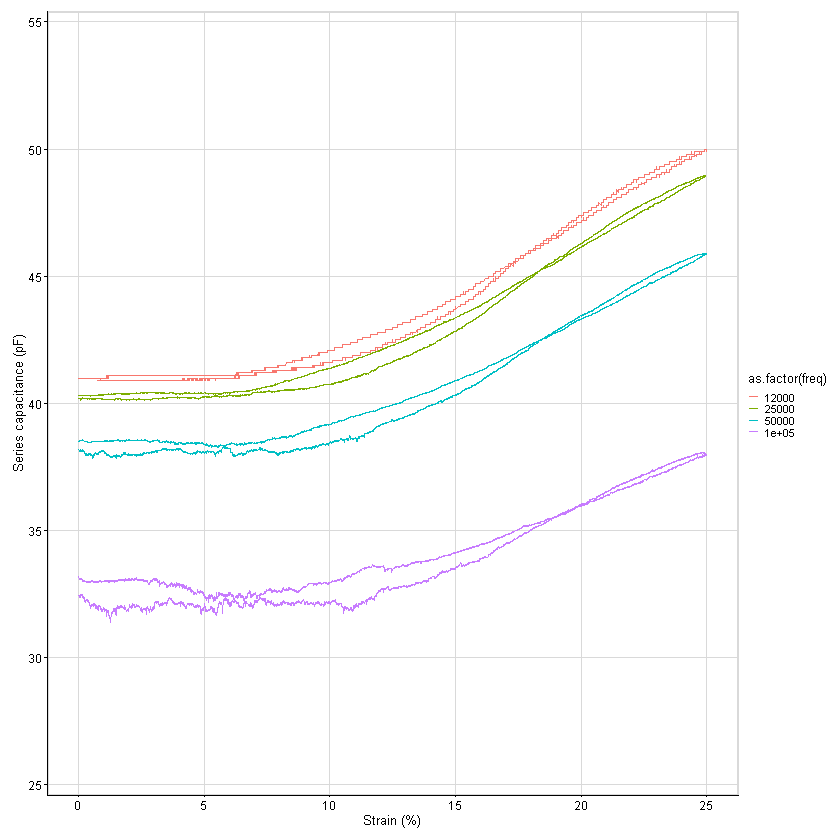

In [6]:
plt1 <- ggplot(subset(data, test.num==4 | test.num==6 | test.num==8 | test.num==9), aes(x=strain, y=Cs, group=freq, colour=as.factor(freq)))
plt1 <- plt1 + geom_path(linewidth=0.5)
plt1 <- plt1 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
plt1 <- plt1 + scale_y_continuous(limits=c(2.6e-11, 5.4e-11), labels=function(x)x*1e12)
plt1 <- plt1 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt1 <- plt1 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt1 <- plt1 + ylab('Series capacitance (pF)')
plt1 <- plt1 + xlab('Strain (%)')
plt1 <- plt1 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt1)

Warning message:
"Removed 11 rows containing missing values (`geom_path()`)."


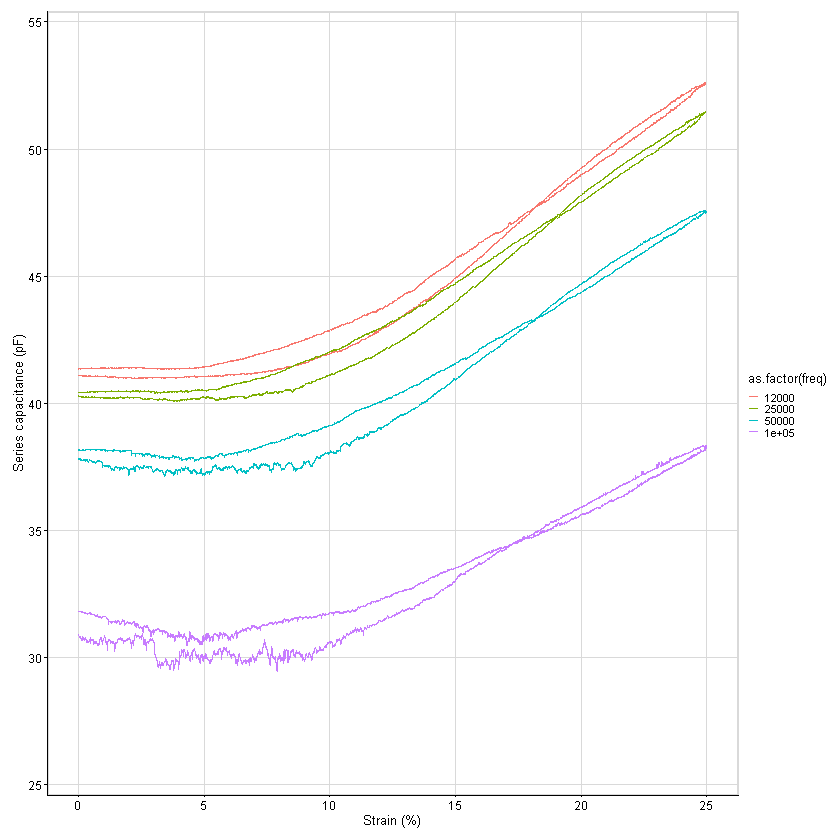

In [7]:
plt2 <- ggplot(subset(data, test.num==25 | test.num==26 | test.num==27 | test.num==28), aes(x=strain, y=Cs, group=freq, colour=as.factor(freq)))
plt2 <- plt2 + geom_path(linewidth=0.5)
plt2 <- plt2 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
plt2 <- plt2 + scale_y_continuous(limits=c(2.6e-11, 5.4e-11), labels=function(x)x*1e12)
plt2 <- plt2 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt2 <- plt2 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt2 <- plt2 + ylab('Series capacitance (pF)')
plt2 <- plt2 + xlab('Strain (%)')
# plt3 <- plt3 + ggtitle("1000 Cycles")
# plt3 <- plt3 + panel_border() + background_grid(major="xy", minor=NA, size.major=0.25)
# plt3 <- plt3 + theme(panel.grid.major = element_line(colour="#EBEBEB", linewidth=0.25), axis.title.y = element_text(colour = "slateblue"), axis.text.y = element_text(color = "slateblue"), axis.line.y = element_line(color = "slateblue"))
plt2 <- plt2 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt2)

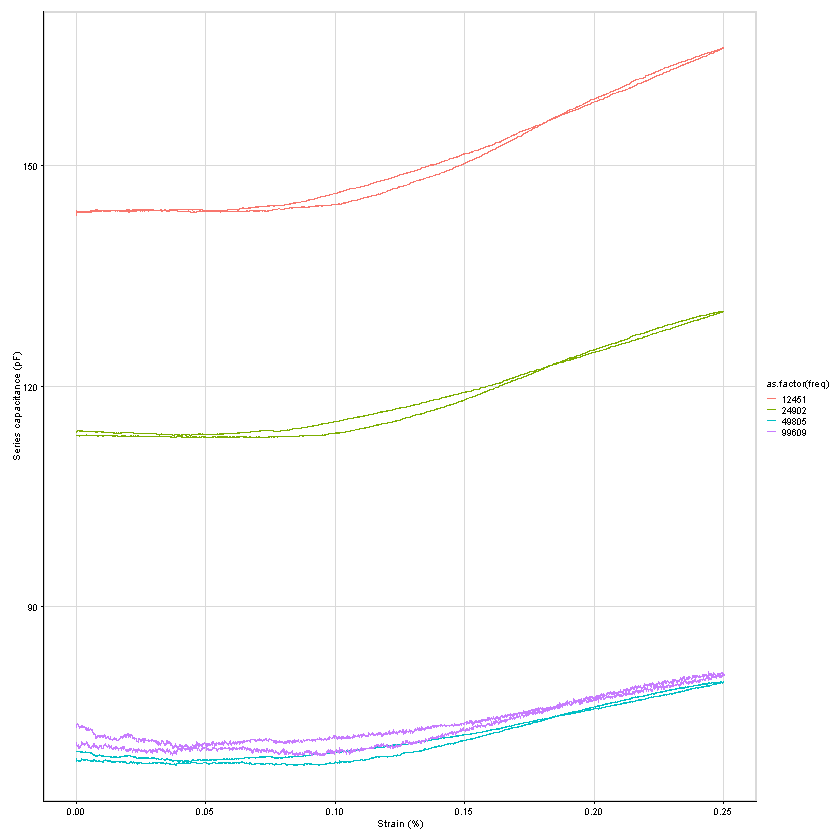

In [8]:
plt3 <- ggplot(subset(data, test.num==13), aes(x=strain, y=Cs, group=freq, colour=as.factor(freq)))
plt3 <- plt3 + geom_path(linewidth=0.5)
#plt3 <- plt3 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
plt3 <- plt3 + scale_y_continuous(labels=function(x)x*1e12)
plt3 <- plt3 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt3 <- plt3 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt3 <- plt3 + ylab('Series capacitance (pF)')
plt3 <- plt3 + xlab('Strain (%)')
# plt3 <- plt3 + ggtitle("1000 Cycles")
# plt3 <- plt3 + panel_border() + background_grid(major="xy", minor=NA, size.major=0.25)
# plt3 <- plt3 + theme(panel.grid.major = element_line(colour="#EBEBEB", linewidth=0.25), axis.title.y = element_text(colour = "slateblue"), axis.text.y = element_text(color = "slateblue"), axis.line.y = element_line(color = "slateblue"))
# plt3 <- plt3 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt3)

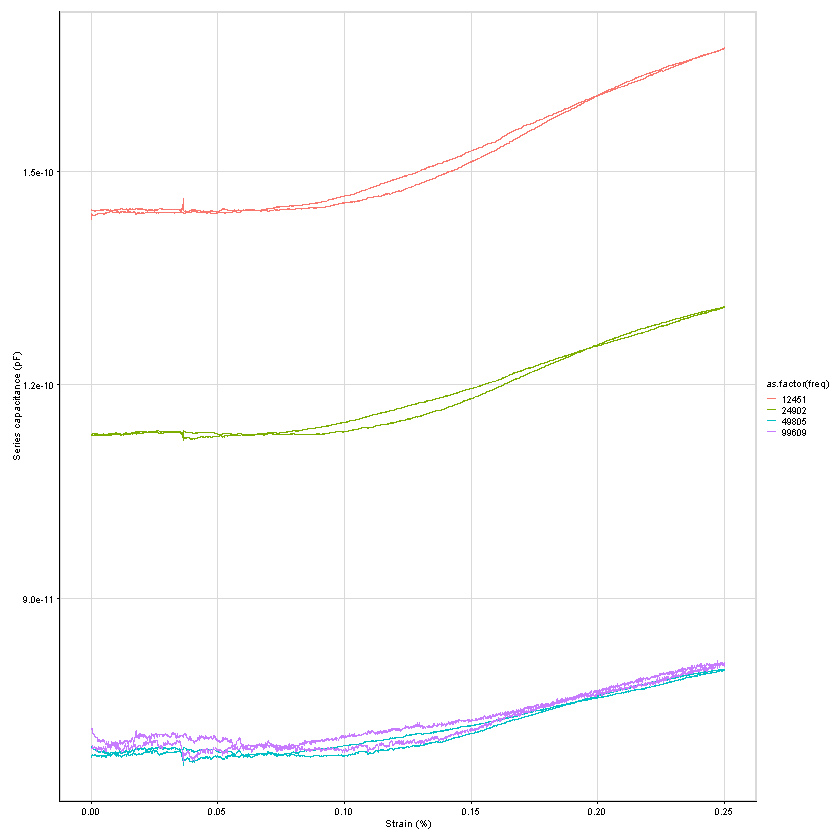

In [9]:
plt3 <- ggplot(subset(data, test.num==21), aes(x=strain, y=Cs, group=freq, colour=as.factor(freq)))
plt3 <- plt3 + geom_path(linewidth=0.5)
#plt3 <- plt3 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
#plt3 <- plt3 + scale_y_continuous(limits=c(2.6e-11, 5.4e-11), labels=function(x)x*1e12)
plt3 <- plt3 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt3 <- plt3 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt3 <- plt3 + ylab('Series capacitance (pF)')
plt3 <- plt3 + xlab('Strain (%)')
# plt3 <- plt3 + ggtitle("1000 Cycles")
# plt3 <- plt3 + panel_border() + background_grid(major="xy", minor=NA, size.major=0.25)
# plt3 <- plt3 + theme(panel.grid.major = element_line(colour="#EBEBEB", linewidth=0.25), axis.title.y = element_text(colour = "slateblue"), axis.text.y = element_text(color = "slateblue"), axis.line.y = element_line(color = "slateblue"))
# plt3 <- plt3 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt3)

## Cyclic Test

The sensor was exposed to 1000 cycles and measured using the sensor board at the 4 excitation frequencies to observe any change or drift in the signals.

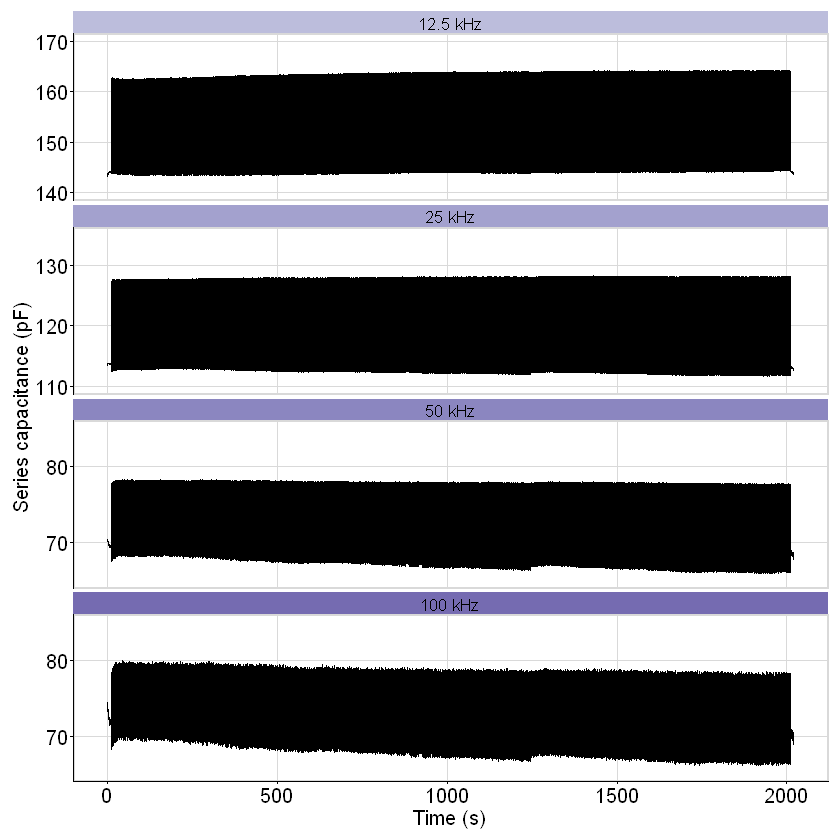

In [10]:
strip <- strip_themed(background_x = elem_list_rect(fill = c('#bcbddc', '#a3a1ce', '#8b86c0', '#756bb1')))
# Change labels to roman numerals.
freq_labeller <- as_labeller(c(
  `99609`="100 kHz",
  `49805`="50 kHz",
  `24902`="25 kHz",
  `12451`="12.5 kHz"
))
scales <- list(
    scale_y_continuous(lim=c(140e-12, 170e-12), breaks=c(140e-12, 150e-12, 160e-12, 170e-12), labels=function(x)x*1e12),
    scale_y_continuous(lim=c(110e-12, 135e-12), breaks=c(110e-12, 120e-12, 130e-12), labels=function(x)x*1e12),
    scale_y_continuous(lim=c(65e-12, 85e-12), breaks=c(70e-12, 80e-12), labels=function(x)x*1e12),
    scale_y_continuous(lim=c(65e-12, 85e-12), breaks=c(70e-12, 80e-12), labels=function(x)x*1e12)
)

plt2 <- ggplot(subset(data, test.num==15), aes(x=time, y=Cs, group=as.factor(freq)))
plt2 <- plt2 + geom_path(linewidth=0.5)
plt2 <- plt2 + scale_x_continuous()
plt2 <- plt2 + scale_y_continuous(labels=function(x)x*1e12)
#plt2 <- plt2 + scale_color_gradient(low='#bcbddc', high='#756bb1', labels=function(x)x*100, name="Frequency", guide="none")                       
plt2 <- plt2 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt2 <- plt2 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt2 <- plt2 + ylab('Series capacitance (pF)')
plt2 <- plt2 + xlab('Time (s)')
plt2 <- plt2 + facet_wrap2(vars(freq), nrow=4, scales="free_y", labeller=freq_labeller, strip=strip)
plt2 <- plt2 + facetted_pos_scales(y=scales)
plt2 <- plt2 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=12), axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12))

print(plt2)

## Pre-Cyclic Testing Response

Readout board measurement of response to triangular strain profile before the cyclic test.

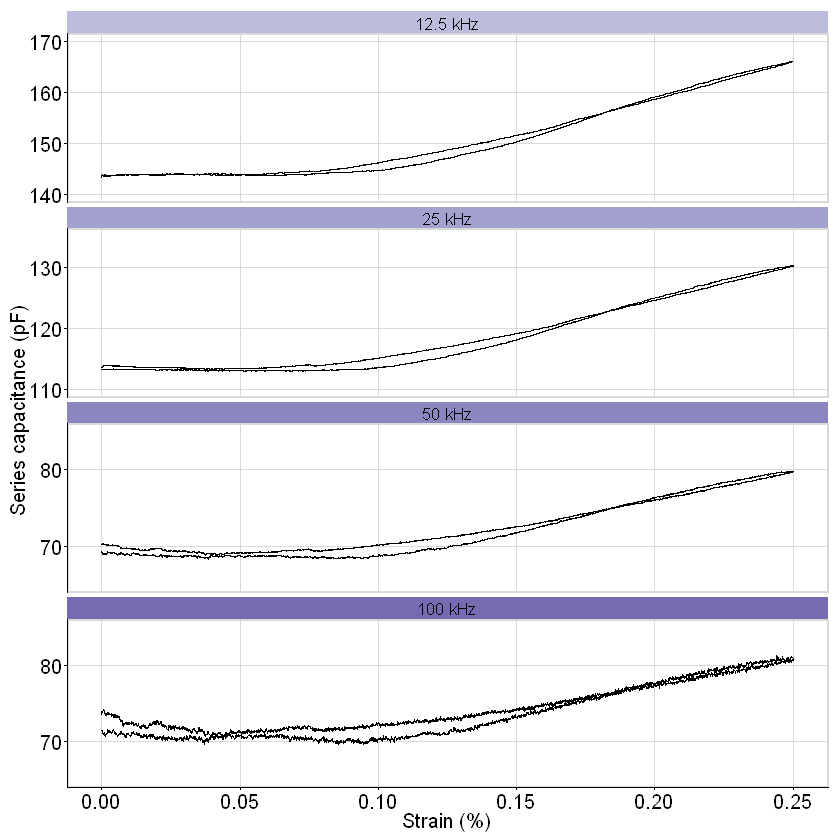

In [11]:
plt1 <- ggplot(subset(data, test.num==13), aes(x=strain, y=Cs, group=freq))
plt1 <- plt1 + geom_path(linewidth=0.5)
#plt1 <- plt1 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
#plt1 <- plt1 + scale_y_continuous(labels=function(x)x*1e12)
plt1 <- plt1 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt1 <- plt1 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt1 <- plt1 + ylab('Series capacitance (pF)')
plt1 <- plt1 + xlab('Strain (%)')
plt1 <- plt1 + facet_wrap2(vars(freq), nrow=4, scales="free_y", labeller=freq_labeller, strip=strip)
plt1 <- plt1 + facetted_pos_scales(y=scales)
plt1 <- plt1 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=12), axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12))
                       
print(plt1)

## Post Cyclic-Testing Response

Readout board measurement of response to triangular strain profile after the cyclic test.

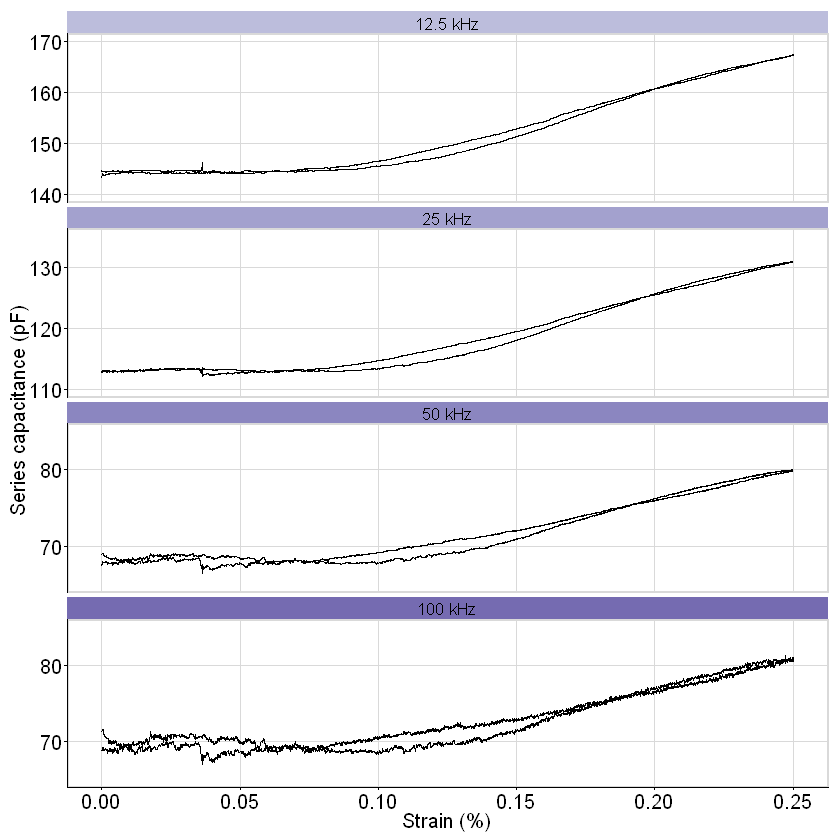

In [12]:
plt3 <- ggplot(subset(data, test.num==21), aes(x=strain, y=Cs, group=freq))
plt3 <- plt3 + geom_path(linewidth=0.5)
#plt3 <- plt3 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
plt3 <- plt3 + scale_y_continuous(labels=function(x)x*1e12)
plt3 <- plt3 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt3 <- plt3 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt3 <- plt3 + ylab('Series capacitance (pF)')
plt3 <- plt3 + xlab('Strain (%)')
plt3 <- plt3 + facet_wrap2(vars(freq), nrow=4, scales="free_y", labeller=freq_labeller, strip=strip)
plt3 <- plt3 + facetted_pos_scales(y=scales)
plt3 <- plt3 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=12), axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12))
                                  
print(plt3)

## Pre Cyclic-Testing Sensitivity

LCR characterization of sensitivity to triangular strain profile before the cyclic test.

In [13]:
plots_upper <- plot_grid(plt1, plt2, plt3, labels=c("a", "b", "c"), rel_widths=c(0.2, 0.6, 0.2), hjust=0.02, nrow=1)
#ggsave('FigS8.png', width=180, height=70, units="mm", dpi=600, bg="white", scale=1.5)
#ggsave("FigS8.eps", width=180, height=70, units="mm", scale=1.5, bg="white", device=cairo_ps, fallback_resolution=600)

In [14]:
gf_init <- subset(data, test.num==10 | test.num==11 | test.num==12) %>%
    group_by(segment) %>%
        group_modify(~ tidy(lm(dCC0 ~ strain + 0, data=.))) %>%
            filter(term=='strain') %>%
                select(segment, estimate)
gf_init

segment,estimate
<chr>,<dbl>
ALL,0.80854684
BOT,2.36769414
TOP,0.01340877


Warning message:
"Removed 56 rows containing missing values (`geom_path()`)."


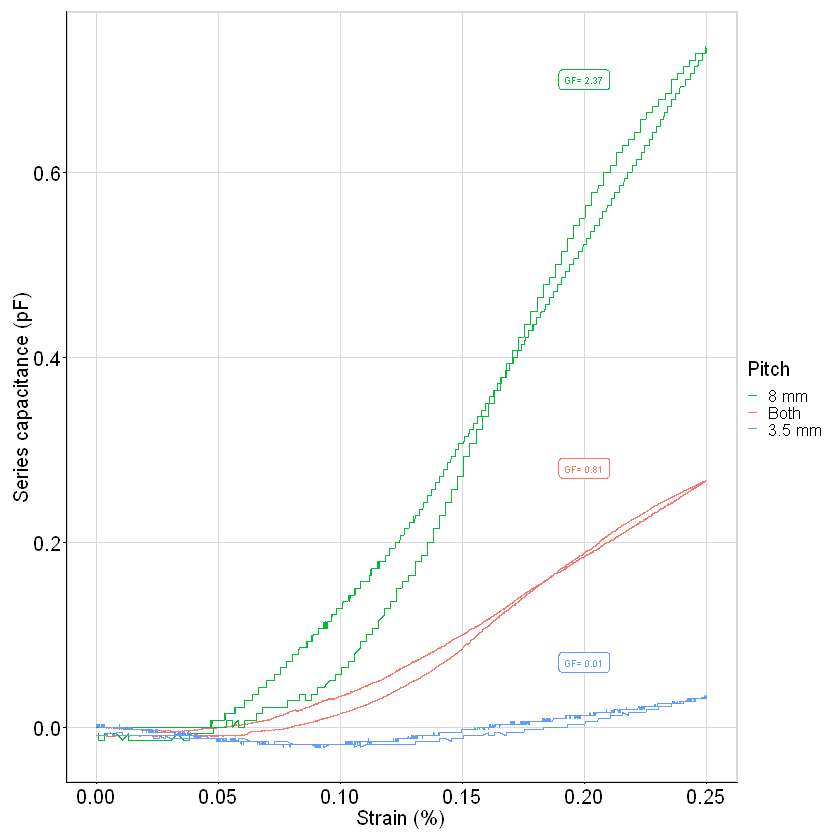

In [15]:
plt4 <- ggplot(subset(data, test.num==10 | test.num==11 | test.num==12), aes(x=strain, y=dCC0, group=segment, colour=segment))
plt4 <- plt4 + geom_path(linewidth=0.5)
#plt4 <- plt4 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
#plt4 <- plt4 + scale_y_continuous(labels=function(x)x*1e12)
plt4 <- plt4 + geom_label(data=gf_init, mapping=aes(label=paste('GF=', round(estimate, 2))), x=0.2, y=c(0.28, 0.7, 0.07), size=2, show.legend=FALSE)
plt4 <- plt4 + scale_colour_discrete(breaks=c("BOT", "ALL", "TOP"), labels = c('8 mm','Both','3.5 mm'), name="Pitch")
plt4 <- plt4 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt4 <- plt4 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt4 <- plt4 + ylab('Series capacitance (pF)')
plt4 <- plt4 + xlab('Strain (%)')
#plt4 <- plt4 + facet_wrap2(vars(freq), nrow=4, scales="free_y", labeller=freq_labeller, strip=strip)
#plt4 <- plt4 + facetted_pos_scales(y=scales)
plt4 <- plt4 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=12), axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12))
                                  
print(plt4)

## Post Cyclic-Testing Sensitivity

LCR characterization of sensitivity to triangular strain profile after the cyclic test.

In [16]:
gf_final <- subset(data, test.num==22 | test.num==23 | test.num==24) %>%
    group_by(segment) %>%
        group_modify(~ tidy(lm(dCC0 ~ strain + 0, data=.))) %>%
            filter(term=='strain') %>%
                select(segment, estimate)
gf_final

segment,estimate
<chr>,<dbl>
ALL,0.83600395
BOT,2.28706437
TOP,0.01747423


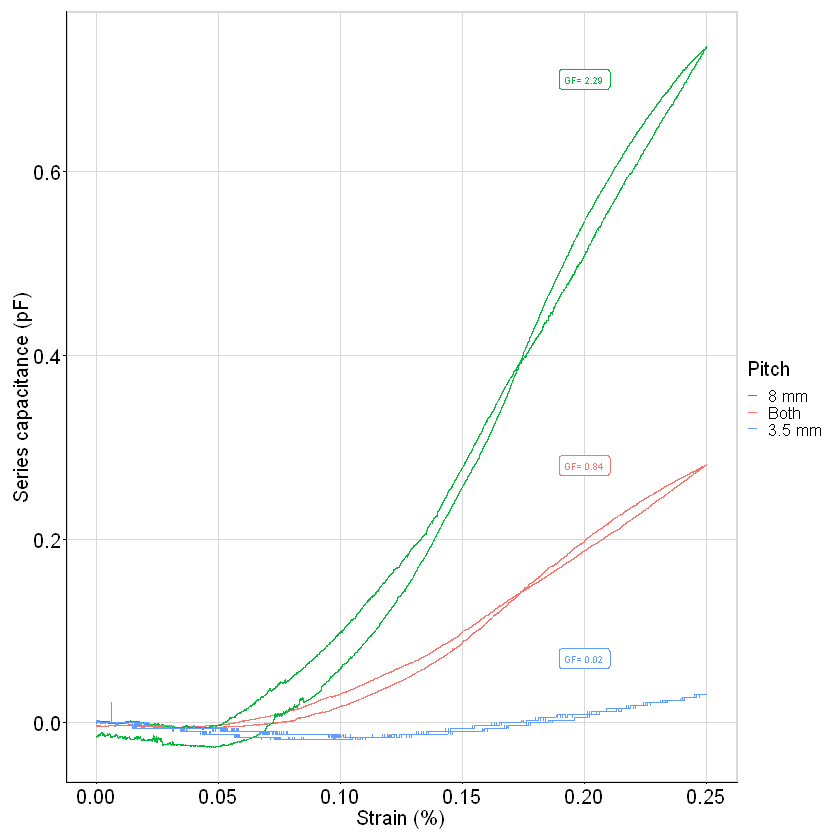

In [17]:
plt5 <- ggplot(subset(data, test.num==22 | test.num==23 | test.num==24), aes(x=strain, y=dCC0, group=segment, colour=segment))
plt5 <- plt5 + geom_path(linewidth=0.5)
#plt5 <- plt5 + scale_x_continuous(limits=c(0, 0.25), labels=function(x)x*100)
#plt5 <- plt5 + scale_y_continuous(labels=function(x)x*1e12)
plt5 <- plt5 + geom_label(data=gf_final, mapping=aes(label=paste('GF=', round(estimate, 2))), x=0.2, y=c(0.28, 0.7, 0.07), size=2, show.legend=FALSE)
plt5 <- plt5 + scale_colour_discrete(breaks=c("BOT", "ALL", "TOP"), labels = c('8 mm','Both','3.5 mm'), name="Pitch")
plt5 <- plt5 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt5 <- plt5 + panel_border() + background_grid(major="xy", minor="", size.major=0.25, size.minor=0.1)
plt5 <- plt5 + ylab('Series capacitance (pF)')
plt5 <- plt5 + xlab('Strain (%)')
#plt5 <- plt5 + facet_wrap2(vars(freq), nrow=4, scales="free_y", labeller=freq_labeller, strip=strip)
#plt5 <- plt5 + facetted_pos_scales(y=scales)
plt5 <- plt5 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=12), axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12))
                                  
print(plt5)

## Photo of Test Sample

Photographs of test sample relaxed and at 25% strain.

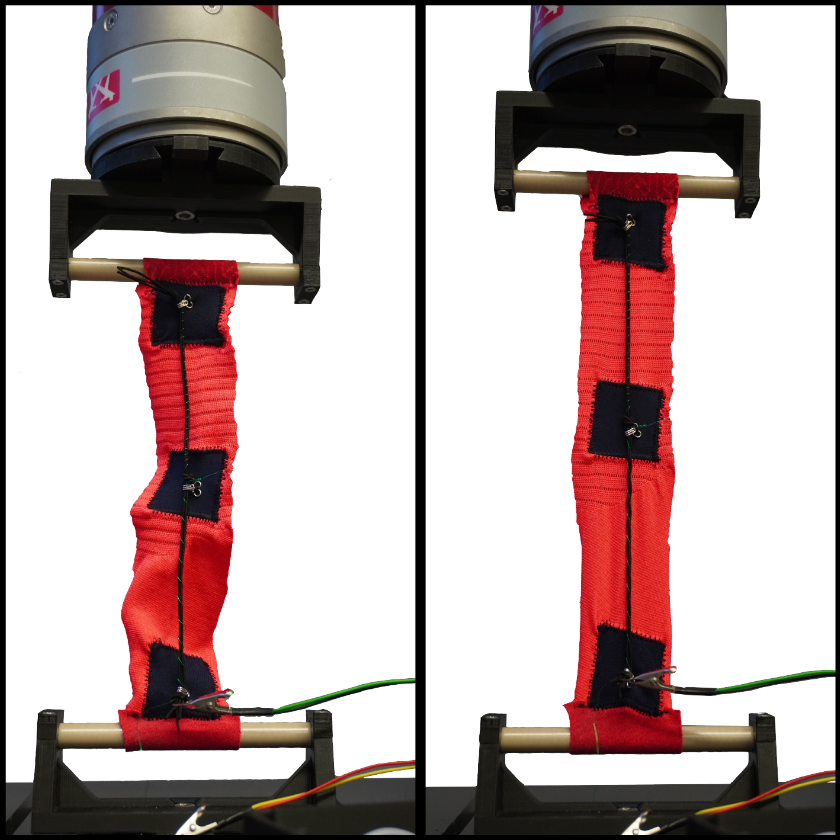

In [18]:
straining_photo <- ".\\Data\\Photos\\Straining.png"
straining_photo <- ggdraw() + draw_image(straining_photo, scale=1)
straining_photo

## Compile Figure

Combine the plots and save as PNG, EPS.

In [19]:
plots_lower <- plot_grid(plt4, straining_photo, plt5, labels=c("d", "e", "f"), rel_widths=c(0.35, 0.3, 0.35), hjust=0.02, nrow=1)
plots_all <- plot_grid(plots_upper, plots_lower, nrow=2, rel_heights=c(70, 40))
ggsave('FigS8.png', width=180, height=110, units="mm", dpi=600, bg="white", scale=1.5)
ggsave("FigS8.eps", width=180, height=110, units="mm", scale=1.5, bg="white", device=cairo_ps, fallback_resolution=600)

Warning message:
"Removed 56 rows containing missing values (`geom_path()`)."
